### Objective
Testing whether or not the global temperater has risen over the period fo 1960and 2012 using a time series analysis.

In [53]:
# import packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
# from fbprophet import Prophet

%matplotlib inline

In [ ]:
1) Global

In [2]:
# bring in the monthly global temperature data
df_temp_raw = pd.read_csv('..\data\GlobalTemperatures.csv', header=0, parse_dates=[0], index_col=0, squeeze=True)

# define start and end date 
START_DT = '1960-01-01'
END_DT = '2012-12-31'

# create a dataframe for Annualized Average Temperature
df_temp_yr = df_temp_raw.loc[START_DT:END_DT].LandAverageTemperature.resample('A').mean()
df_temp_yr.head()

dt
1960-12-31    8.583750
1961-12-31    8.797667
1962-12-31    8.745917
1963-12-31    8.856000
1964-12-31    8.409667
Freq: A-DEC, Name: LandAverageTemperature, dtype: float64

### Modeling 1: Structural Modeling/Decomposition

Structural Modeling views a given time series as a function of a general trend, along with a seasonal cycle.

$xt=Tt+St+Nt$
 
where
$T_t$ = trend component,
$S_t$ = seasonal component,
$N_t$ = noise.

We will essentially estimate the effect that each component has on the series that we are faced with, at different points in that series.

This procedure is so popular that it gets its own function. There are two parameters that we will want to set - first is the model parameter, which we set to 'additive,' as indicated by the above specification. We are also going to need to set the freq parameter, which is referring to the periodicity of the time series. In our case, I explored several options ranging from 20 to 30 years based on the Forbes article, and settled on 25 years.

In [3]:
decomp = seasonal_decompose(x=df_temp_yr, model='additive', freq=25)

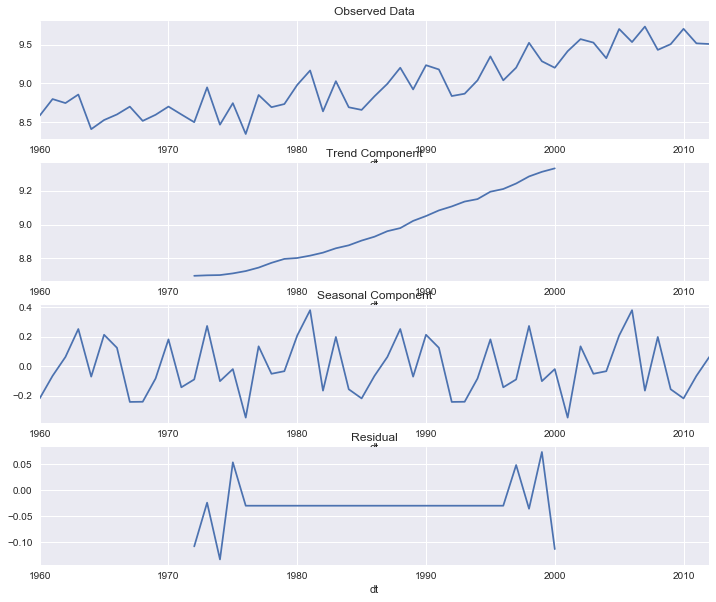

In [4]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(12,10))
decomp.observed.plot(ax=ax1)
ax1.set_title('Observed Data')
decomp.trend.plot(ax=ax2)
ax2.set_title('Trend Component')
decomp.seasonal.plot(ax=ax3)
ax3.set_title('Seasonal Component')
decomp.resid.plot(ax=ax4)
ax4.set_title('Residual');

These results are interesting. First, we are presented with average temperatures. Next, we are given the general trend component. From this, we can see an obvious pattern - global temperature has been increasing over time. We can also see a changepoint occuring right after the trend line becomes available, and we can see that the rate at which average temperature has risen is linear. Now, let's fit a trend line on decomposed trend temperatures and get stats on it to better understand the trend.

In [66]:
df_trend = pd.DataFrame(decomp.trend).reset_index().dropna()
df_trend['year'] = df_trend.dt.dt.year

C:\Users\m187531\AppData\Local\conda\conda\envs\my_root\lib\site-packages\scipy\stats\stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


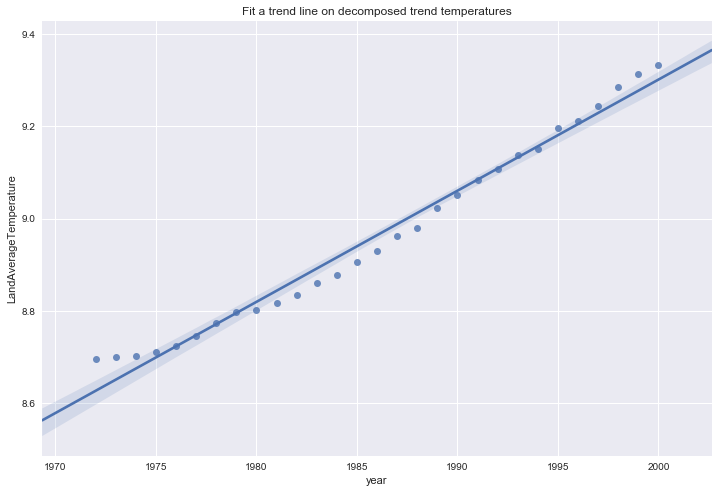

In [67]:
plt.figure(figsize=(12,8))
plt.title('Fit a trend line on decomposed trend temperatures')
sns.regplot(x='year', y='LandAverageTemperature', data=df_trend);

In [69]:
# get stats on the fitted line
slope, intercept, r_value, p_value, std_err = stats.linregress(df_trend['year'], df_trend['LandAverageTemperature'])

In [70]:
print('slope: ' + str(slope))
print('p-value: ' + str(p_value))

slope: 0.024073975369458055
p-value: 3.3580736844625425e-25


The fitted trend line has a slope of 0.024 with P-value of 3.35e-25. This indicates that global average temparatures have risen by 0.024 celcius degree every year since 1972. This chart confirms that the global warming has occured during this time period.

#### 2) individual view

While our analysis above confirms there is a upward linear trend in global between 1960 and 2012, we would like to investigate further at the country level to get a sense of the varition of trends in temperature at each country. Our questions in this section include:

* Temparature increase observed at the global level is consistent across all countries?
* Is there any variation in temparature change among countries depending on 1) proximity to higher levels Co2 and/or 2) Co2 emission


In [5]:
# load and clean dataset
df = pd.read_csv('../data/ADS_project_dataset2.csv', header=0, parse_dates=[0], squeeze=True)

df_small = df[(df.Year >= 1960) & (df.Year <= 2012)]\
    .loc[:,['Country', 'Year', 'AveTemperature']]\
    .sort_values(['Country', 'Year'])\
    .reset_index(drop=True)

df_small.Year = pd.to_datetime(df_small.Year, format='%Y')
df_small = df_small.set_index('Year')

In [6]:
df_small.head()

,Country,AveTemperature
Year,,
1960-01-01,Afghanistan,13.985417
1961-01-01,Afghanistan,14.064917
1962-01-01,Afghanistan,13.768667
1963-01-01,Afghanistan,15.033417
1964-01-01,Afghanistan,13.084917


In [7]:
df_small.describe()

,AveTemperature
count,9275.000000
mean,18.933613
std,8.694618
min,-19.857750
25%,11.534875
50%,22.365750
75%,26.208792
max,30.127083


In [8]:
df_small.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9275 entries, 1960-01-01 to 2012-01-01
Data columns (total 2 columns):
Country           9275 non-null object
AveTemperature    9275 non-null float64
dtypes: float64(1), object(1)
memory usage: 217.4+ KB


In [9]:
list_country = list(df_small.Country.unique())

In [101]:
df_master_result = pd.DataFrame()

In [102]:
# decompose temperatures for each country
for i in list_country:
    series_temp = df_small[df_small['Country'] == i]['AveTemperature']
    decomp_result = seasonal_decompose(x=series_temp, model='additive', freq=25)
    slope, intercept, r_value, p_value, std_err = stats.linregress(df_trend['year'], df_trend['LandAverageTemperature'])
    df_result = pd.DataFrame({'observed': decomp_result.observed,
              'country': i,
              'trend': decomp_result.trend,
              'seasonal': decomp_result.seasonal,
              'resid': decomp_result.resid})
    df_master_result = df_master_result.append(df_result)

In [129]:
# fit a trend line on decomposed trend temparatures
list_country_master = []
list_slope_master = []
list_intercept_master = []
list_r_value_master = []
list_p_value_master = []
list_std_err_master = []

for j in list_country:
    df_result = df_master_result_sm[df_master_result_sm.country == j].dropna()
    slope, intercept, r_value, p_value, std_err = stats.linregress(df_result.index, df_result.trend)
    list_country_master.append(j)
    list_slope_master.append(slope)
    list_intercept_master.append(intercept)
    list_r_value_master.append(r_value)
    list_p_value_master.append(p_value)
    list_std_err_master.append(std_err)

df_fit = pd.DataFrame(
    {
        'country':list_country_master,
        'slope':list_slope_master,
        'intercept':list_intercept_master,
        'r_value':list_r_value_master,
        'p_value':list_p_value_master,
        'std_err':list_std_err_master
             })

In [131]:
df_fit.head()

,country,intercept,p_value,r_value,slope,std_err
0,Afghanistan,13.578291,1.415715e-23,0.988272,0.037527,0.001116
1,Albania,10.975828,4.709614e-17,0.963947,0.024808,0.001318
2,Algeria,19.000433,4.063175e-20,0.978760,0.034009,0.001371
3,Andorra,4.979286,8.427931e-26,0.991989,0.036405,0.000892
4,Angola,16.929805,2.394979e-23,0.987804,0.022256,0.000675


In [136]:
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--', color='grey')

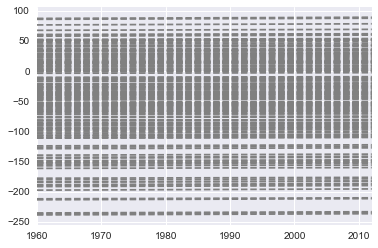

In [142]:
for k in range(df_fit.shape[0]):
    plt.xlim(1960, 2012)
    abline(df_fit['slope'][k], df_fit['intercept'][k])

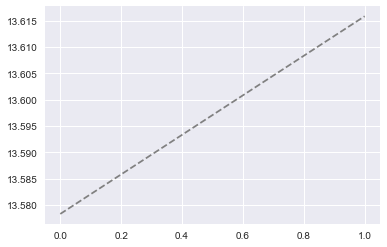

In [137]:
abline(0.037527, 13.578291)

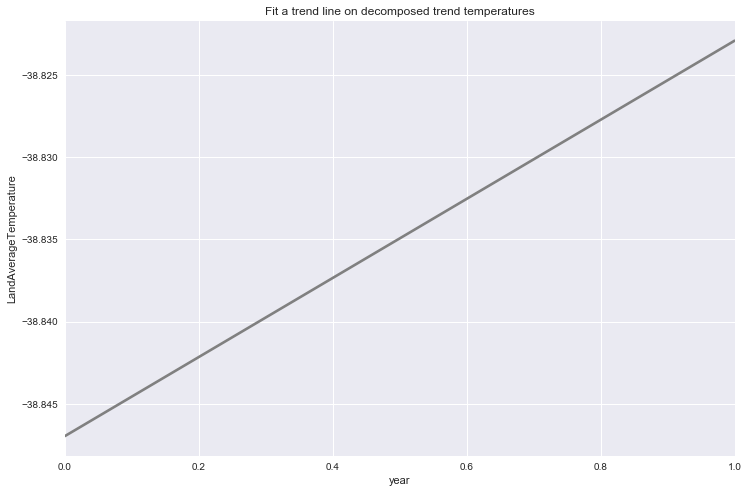

In [152]:
plt.figure(figsize=(12,8))
plt.title('Fit a trend line on decomposed trend temperatures')
sns.regplot(x='year', y='LandAverageTemperature', scatter=False, ci=None, color='grey', data=df_trend)

In [13]:
# transform results for visual
df_trans_result = df_master_result\
    .reset_index()\
    .pivot(index='Year',
           columns='country',
           values='trend')\
    .dropna()

In [14]:
x = np.linspace(0, 15, 31)
data = np.sin(x) + np.random.rand(10, 31) + np.random.randn(10, 1)
df = pd.DataFrame(data).melt()

C:\Users\m187531\AppData\Local\conda\conda\envs\my_root\lib\site-packages\scipy\stats\stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


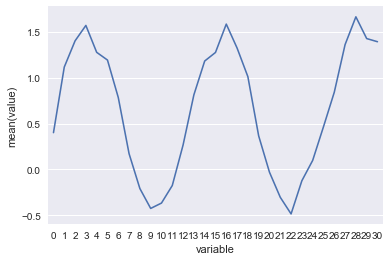

In [73]:
sns.pointplot(x="variable", 
              y="value", 
              scale=0.5, 
              markers='',
              ci=False,
              data=df)

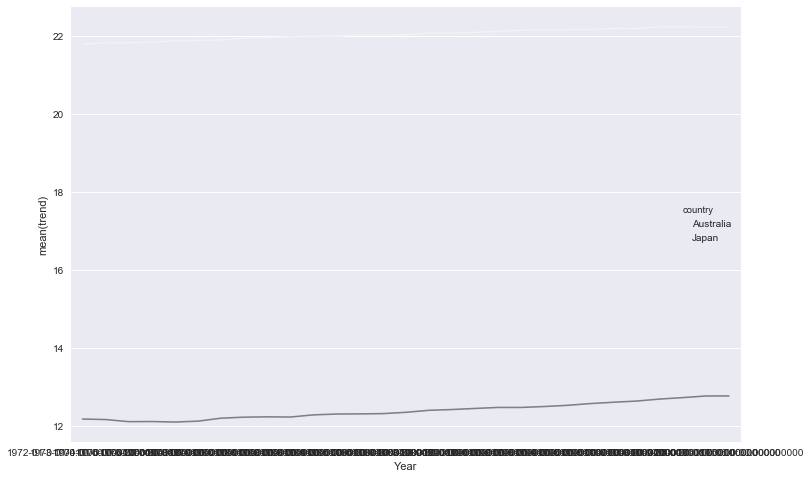

In [82]:
plt.figure(figsize=(12,8))
sns.pointplot(x=df_vis_test.index, 
              y='trend', 
              hue='country', 
              scale=0.5, 
              markers='',
              color='grey', 
              lenged=False, 
              data=df_vis_test)

In [81]:
df_vis_test = df_master_result[df_master_result.country.isin(['Japan', 'Australia'])].dropna()